# Spectra

Once you have procured your astronomical observations, the first step in the analysis of spectroscopic lines is opening the files with the actual scientific data. In most cases, this is a *.fits* file. The reader is recomended to check the [official *.fits* tutorial](https://docs.astropy.org/en/stable/io/fits/) from [astropy](https://www.astropy.org/).

Not all the astronomical instruments store the data in *.fits* files in the same way. $LiMe$ has the capability to read *.fits* files from certain instruments.

In this tutorial, we are going to explore both aproaches: Using $LiMe$ functions and using astropy and numpy to extract the scientific data. The readers are encouraged to contact the author to request that their spectra is added instrument list.

This tutorial can be found as a notebook in the Github [examples/inputs](https://github.com/Vital-Fernandez/lime/tree/master/examples/inputs) folder.

## 1) $LiMe$ *.fits* reading functions

To check the list of suported instruments use the ``lime.show_instrument_cfg`` function:

In [1]:
import lime
from pathlib import Path

lime.show_instrument_cfg()


Single ".fits" spectra files configuration:
0 nirspec) 	 units_wave: um, units_flux: MJy, pixel_mask: nan, inst_FWHM: None
1 isis) 	 units_wave: Angstrom, units_flux: FLAM, pixel_mask: nan, inst_FWHM: None
2 osiris) 	 units_wave: Angstrom, units_flux: FLAM, pixel_mask: nan, inst_FWHM: None
3 sdss) 	 units_wave: Angstrom, units_flux: 1e-17*FLAM, pixel_mask: nan, inst_FWHM: None
4 desi) 	 units_wave: Angstrom, units_flux: 1e-17*FLAM, pixel_mask: nan, inst_FWHM: None

Cube ".fits" spectra files configuration:
0 manga) 	 units_wave: Angstrom, units_flux: 1e-17*FLAM,pixel_mask: nan, inst_FWHM: None
1 muse) 	 units_wave: Angstrom, units_flux: 1e-20*FLAM,pixel_mask: nan, inst_FWHM: None
2 megara) 	 units_wave: Angstrom, units_flux: Jy,pixel_mask: nan, inst_FWHM: None


The first list corresponds to the instrument observations, which can be read with the ``lime.Spectrum.from_file`` function as longslit spectra, while the second list corresponds to the observations the ``lime.Cube.from_file`` loads as IFU cubes. These are some of the parameters from the  and the  functions respectively.

The previous command also displays the arguments it provides for the [``lime.Spectrum``](https://lime-stable.readthedocs.io/en/latest/introduction/api.html#lime.Spectrum) and [``lime.Cube``](https://lime-stable.readthedocs.io/en/latest/introduction/api.html#lime.Cube) functions respectively:
* **units_wave**: Spectrum wavelength units.
* **units_flux**: Spectrum flux units. In some cases, these units include the scale (for example ``1e-17``for SDSS spectra) with which the flux is stored. 
* **pixel_mask**: Indeces to mask or entries to mask on the wavelength, flux and uncertainty arrays. In the case of ``pixel_mask=np.nan`` nan entries in either the flux or the uncertainty flux arrays are masked.
* **inst_FWHM**: Spectrograph FWHM.

Additionally, in the case of and IFU observation, the ``lime.Cube.from_file`` function recovers the [World Coordidnate System](https://docs.astropy.org/en/stable/visualization/wcsaxes/index.html) with the observation spatial coordinates.

<div class="alert alert-info">

**Please remember:** These default configuration values from $LiMe$ may not apply to your observation. This is most likely in observations not comming from surveys. Please remember to confirm these units and configuration parameters match your observations.

</div>

Let's start by reading some of the spectra from the  [examples/sample_data](https://github.com/Vital-Fernandez/lime/tree/master/examples/sample_data) folder.

In [2]:
# Specifying inputs:
data_folder = Path('../sample_data/spectra')
sloan_SHOC579 = data_folder/'sdss_dr18_0358-51818-0504.fits'
nirspec_ceers = data_folder/'hlsp_ceers_jwst_nirspec_nirspec10-001027_comb-mgrat_v0.7_x1d-masked.fits'


Now we can open these files with:

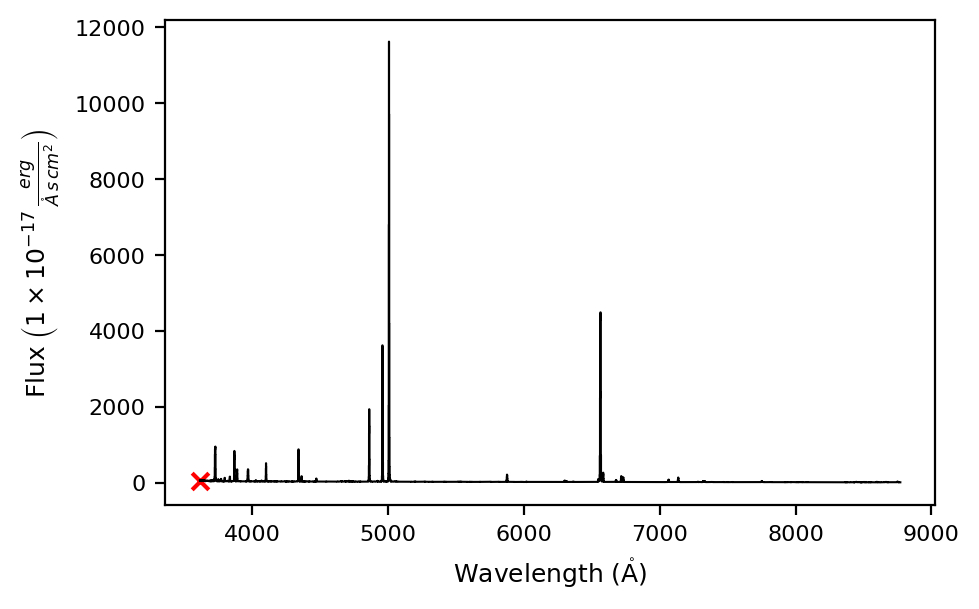

In [3]:
spec_shoc579 = lime.Spectrum.from_file(sloan_SHOC579, instrument='sdss', redshift=0.0475)
spec_shoc579.plot.spectrum(rest_frame=True)

LiMe WARNING: The input err_flux array contains "nan" entries not included on the input pixel_mask array
LiMe INFO: No input flux normalization. Dividing flux by 1e-08


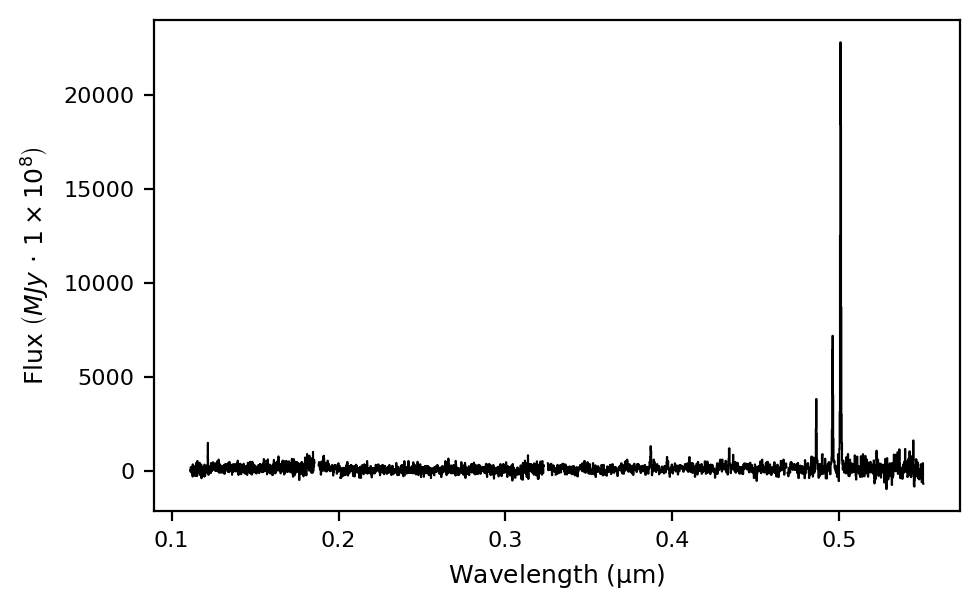

In [6]:
spec_ceers = lime.Spectrum.from_file(nirspec_ceers, instrument='nirspec', redshift=7.8189)
spec_ceers.plot.spectrum(rest_frame=True)

You may notice that in the previous cases we only provided the observation **redshift** and the **norm_flux**. The spectra units and pixel masks are already provided by the $LiMe$ functions.

## 2) Constructing the $LiMe$ observations from the *.fits* data

Now, we are going to follow the classical approach, where we extract the scientific data from the *.fits* files:

### a) Long-slit spectra

The calibrated spectrum of a long-slit or echelle instrument consists in a container for the photons dispersion/wavelength, flux and in some cases the flux uncertainty. The latter arrays are usually stored in one of the *.fits* extensions, however, you might need to reconstruct the wavelength array from the header keys.  

#### OSIRIS instrument at the Gran Telescopio de Canarias

The long-slit spectra from this instruments follows the IRAF standard reduction. Consequently, a page the wavelength array is computed from the ``CRVAL1``, ``CD1_1`` and ``NAXIS1`` keys.  

Let's start by importing the libraries we are going to use and declare the [folder](https://github.com/Vital-Fernandez/lime/tree/310d42ac507862a472c0bc14d291f216cb05e9d3/docs/source/tutorials/sample_data) with the scientific data:

In [5]:
import numpy as np
from astropy.io import fits
from pathlib import Path
from astropy.wcs import WCS
import lime

# Sample data location
data_folder = Path('../sample_data/spectra')
fits_path = data_folder/'gp121903_osiris.fits'
extension = 0

The extension above specifies the page from the *.fits* file. A quick way to check the extensions in a *.fits* is the [convenience function](https://docs.astropy.org/en/stable/io/fits/index.html#convenience-functions) ``fits.info``:

In [6]:
# Fits file information:
fits.info(fits_path)

Filename: ../sample_data/spectra/gp121903_osiris.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     143   (3199,)   float32   


In this file, there is only one extension, so we can now open the file using the ``astropy.io.fits`` function:

In [7]:
# Open the fits file
with fits.open(fits_path) as hdul:
    flux_array, header = hdul[extension].data, hdul[extension].header

In the code above, we use the [with context manager](https://realpython.com/python-with-statement/). This structure makes sure that the file is closed once we extract the data. This is a safe practice in the case of large *.fits* files.

Now, we are going to compute the wavelength array:

In [8]:
# Reconstruct the wavelength array from the header data
w_min, dw, n_pix = header['CRVAL1'],  header['CD1_1'], header['NAXIS1']
w_max = w_min + dw * n_pix
wave_array = np.linspace(w_min, w_max, n_pix, endpoint=False)
print(wave_array)

[ 3626.97753906  3629.04561139  3631.11368372 ... 10236.5367069
 10238.60477923 10240.67285156]


In this file the ``CRVAL1`` provides the spectrum lowest wavelength, ``CD1_1`` states the wavelength resolution (constant for this instrument) and the integer ``NAXIS1`` is the number of pixels along the dispersion axis.

<div class="alert alert-info">

**Please remember:** Depending on the instrument and on the spectral calibration procedure, reading the data from a **.fits** file can change considerably. Make sure to check the keys description on the header keys and the instrument documentation for the correct procedure.

</div>

The units on the spectrum arrays should also be specified on the *.fits* header:


In [9]:
print(f'Wavelength array: {header["WAT1_001"]}')
print(f'Flux array: {header["BUNIT"]}')

Wavelength array: wtype=linear label=Wavelength units=Angstroms
Flux array: erg/cm2/s/A


Now we have can construct a [``lime.Spectrum``](https://lime-stable.readthedocs.io/en/latest/introduction/api.html#lime.Spectrum):

LiMe INFO: No input flux normalization, using 1e+83


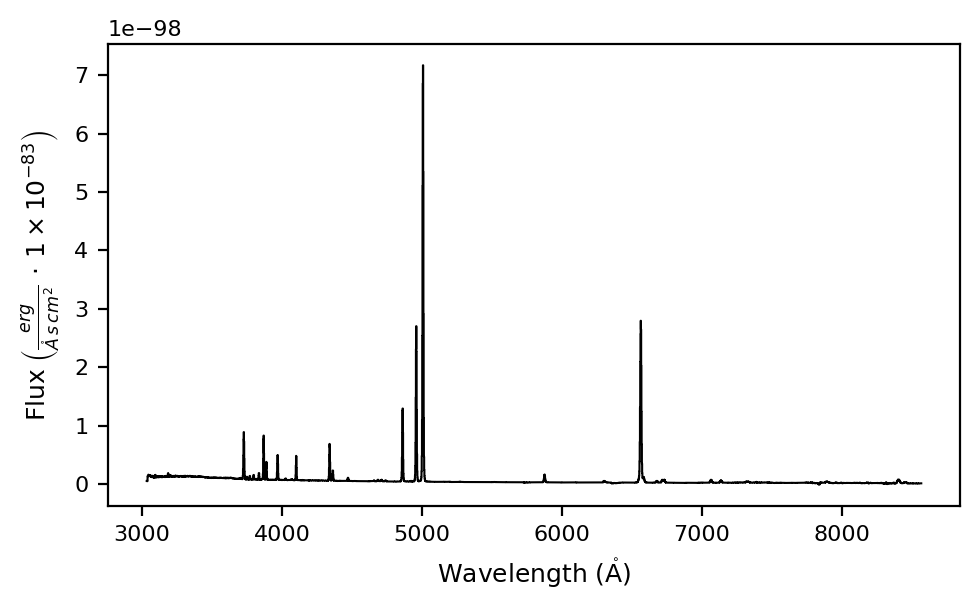

In [10]:
obj = lime.Spectrum(wave_array, flux_array, redshift=0.19531)
obj.plot.spectrum(rest_frame=True)

The default units for the [``lime.Spectrum``](https://lime-stable.readthedocs.io/en/latest/introduction/api.html#lime.Spectrum) and [``lime.Cube``](https://lime-stable.readthedocs.io/en/latest/introduction/api.html#lime.Cube) are ``units_wave="Angstrom"`` and ``units_flux="FLAM"``. Since these default values match the ones in these observations we don't need to provide them.

In the [Centimetre–gram–second](https://en.wikipedia.org/wiki/Centimetre%E2%80%93gram%E2%80%93second_system_of_units) units system, the flux magnitude is ususally several orders below the unit. Trying to fit a profile at such scales will make the minimizer to fail. Consequently, the user is strongly adviced to provide a **norm_flux** argument to divide the flux. The output measurents, however, won't include this normalization.

<div class="alert alert-info">

**Please remember:** If the observation does not include a ``norm_flux`` but the mean spectrum flux value is below 1e-5, $LiMe$ will compute one as in the observation above (notice the terminal message). The user can set ``norm_flux=1`` to avoid the automatic normalization but the fittings will fail if the flux units are very small.

</div>

### b) SDSS spectrum (data release 18)

The *.fits* files from [SDSS survey](https://skyserver.sdss.org/dr18/) are indexed following a dictionary-like structure which includes the wavelength array.

In [11]:
sloan_SHOC579 = data_folder/'sdss_dr18_0358-51818-0504.fits'

To load the data we can use:

In [12]:
# Open the fits file
extension = 1
with fits.open(sloan_SHOC579) as hdul:
    data = hdul[extension].data
    header = hdul[extension].header

The ``flux`` key indexes the flux. This value is normalized by $10^{-17}$. So we are going to define the units including this scale:

In [13]:
flux_array = data['flux']
units_flux = '1e-17*FLAM'

The flux uncertainty is stored as the inversed of the variance. The bad values in this array are set to zero, hence, we are going to mask these values to compute the error spectrum.

In [14]:
ivar_array = data['ivar']
err_array = np.sqrt(1/ivar_array)
pixel_mask = ivar_array == 0

/tmp/ipykernel_30486/3510536718.py:2: RuntimeWarning: divide by zero encountered in divide
  err_array = np.sqrt(1/ivar_array)


Finally, the wavelength array is stored in logarithmic scale and they are accessed via the ``loglam`` key:

In [15]:
wave_vac_array = np.power(10, data['loglam'])

This wavelength array is in vacuum. To convert it to air units we can use the [Morton (1991, ApJS, 77, 119)](https://ui.adsabs.harvard.edu/abs/1991ApJS...77..119M/abstract) law:

In [16]:
wave_array = wave_vac_array / (1.0 + 2.735182E-4 + 131.4182 / wave_vac_array**2 + 2.76249E8 / wave_vac_array**4)

Now we can create the ``Spectrum`` object:

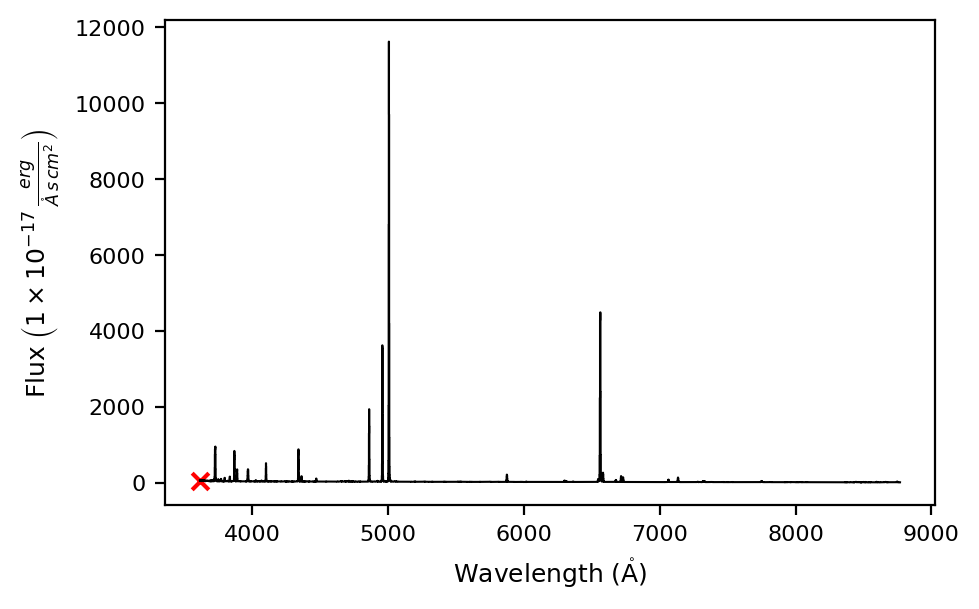

In [17]:
obj = lime.Spectrum(wave_array, flux_array, err_array, pixel_mask=pixel_mask, units_flux=units_flux, redshift=0.0475)
obj.plot.spectrum(rest_frame=True)

## 2) IFU data sets

Integrated field spectrographs provide 3D data array, whose "length" axis corresponds to the dispersion axis while the "height" and "width" axes represent the spatial coordinates. Depending of the instrument, the size of these files can be very large and 3rd party libraries are necessary to open such files.

### a) MANGA survey cubes

As we did in the case of the SDSS survey, we are opening an observation of the SHOC579 galaxy, which we are also analysing in the [4th tutorial](https://lime-stable.readthedocs.io/en/latest/tutorials/notebook4_IFU_Spatial_Masking.html). Please refer to this tutorial on how to obtain this observation:

In [18]:
fits_path = data_folder/'manga-8626-12704-LOGCUBE.fits.gz'

This file is compressed, however, the ``astropy.io.fits.open`` can read it. However, keep in mind that reading compressed files takes more time:

In [19]:
# Open the MANGA cube fits file
with fits.open(fits_path) as hdul:

    # Wavelength 1D array
    wave = hdul['WAVE'].data

    # Flux 3D array
    flux_cube = hdul['FLUX'].data
    units_flux = '1e-17*FLAM'

    # Convert inverse variance cube to standard error, masking 0-value pixels first
    ivar_cube = hdul['IVAR'].data
    #pixel_mask_cube = pixel_mask_cube.reshape(ivar_cube.shape)
    #err_cube = np.sqrt(1/np.ma.masked_array(ivar_cube, pixel_mask_cube)) * 1e-17
    err_cube = np.sqrt(1/ivar_cube)
    pixel_mask_cube = ivar_cube == 0
    
    # Header
    hdr = hdul['FLUX'].header

/tmp/ipykernel_30486/3592354798.py:15: RuntimeWarning: divide by zero encountered in divide
  err_cube = np.sqrt(1/ivar_cube)


The header of *.fits* spectra usually contains the astronomical coordinates of the observation. $LiMe$ relies on astropy [World Coordidnate System](https://docs.astropy.org/en/stable/visualization/wcsaxes/index.html) function, to plot the IFU data and export the coordinates to the output *.fits* with your measurements:

You can create the WCS object from the corresponding *.fits* header:

In [20]:
# WCS from the observation
wcs = WCS(hdr)

a string value was expected. [astropy.wcs.wcs]


Now, we have all the create our Cube object:

In [21]:
cube = lime.Cube(wave, flux_cube, err_cube, redshift=0.0475, units_flux=units_flux, pixel_mask=pixel_mask_cube)

Now you can extract individual spaxels to analyse the object lines. Each spaxel will have its corresponding error spectrum and pixel mask

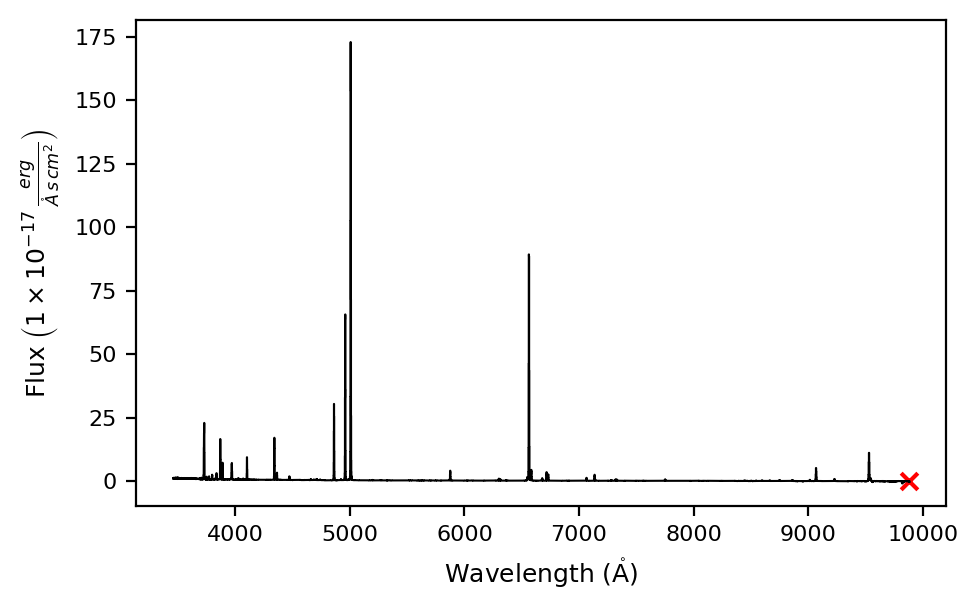

In [22]:
# Extract spaxel
spaxel = cube.get_spectrum(38, 35)

# Plot spectrum
spaxel.plot.spectrum(rest_frame=True)

Finally, we can perform measurements on this spaxel using the ``Spectrum`` attributes

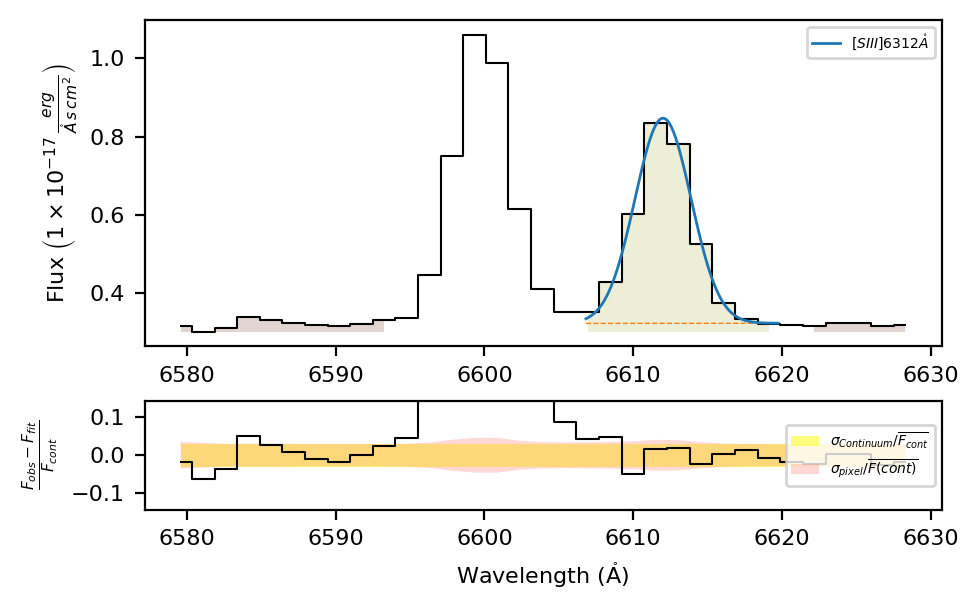

In [23]:
# Fit emission line using the bands from the default database
spaxel.fit.bands('S3_6312A')

# Plot last fitting
spaxel.plot.bands()